In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
folder_path = 'Data/images/cropped_50'
image_size = (50, 50)

In [3]:
def load_data_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(50, 50))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        label = 1 if filename.endswith('T.png') else 0  # 1 for 'T' (with helmet), 0 for 'F' (without helmet)
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
images, labels = load_data_from_folder(folder_path)

X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

model.save('helmet_detection_model.keras')

Epoch 1/50
36/36 [==============================] - 3s 46ms/step - loss: 0.3260 - accuracy: 0.8640 - val_loss: 0.4015 - val_accuracy: 0.8445
Epoch 2/50
36/36 [==============================] - 2s 42ms/step - loss: 0.2347 - accuracy: 0.9170 - val_loss: 0.4914 - val_accuracy: 0.8304
Epoch 3/50
9/9 [==============================] - 0s 19ms/step - loss: 0.4015 - accuracy: 0.8445
Test Accuracy: 84.45%


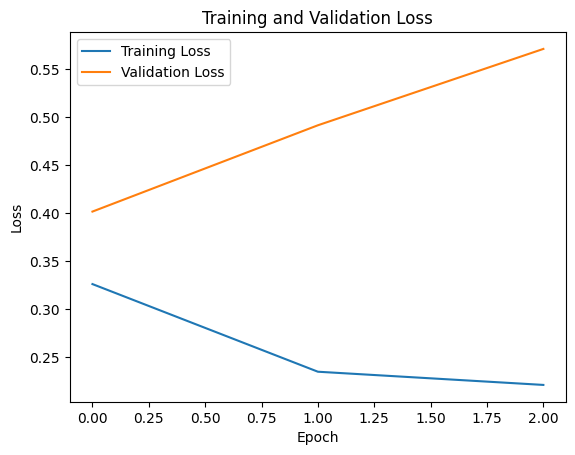

In [14]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()